In [2]:
import numpy as np
from scipy.optimize import root_scalar, root
import matplotlib.pyplot as plt 
from numpy.linalg import eigvals
from scipy.optimize import minimize
from scipy.optimize import fsolve 

/var/folders/1q/ck574qds4v36l1t2j4jftvq80000gn/T/ipykernel_56458/341355812.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  s = float(s)


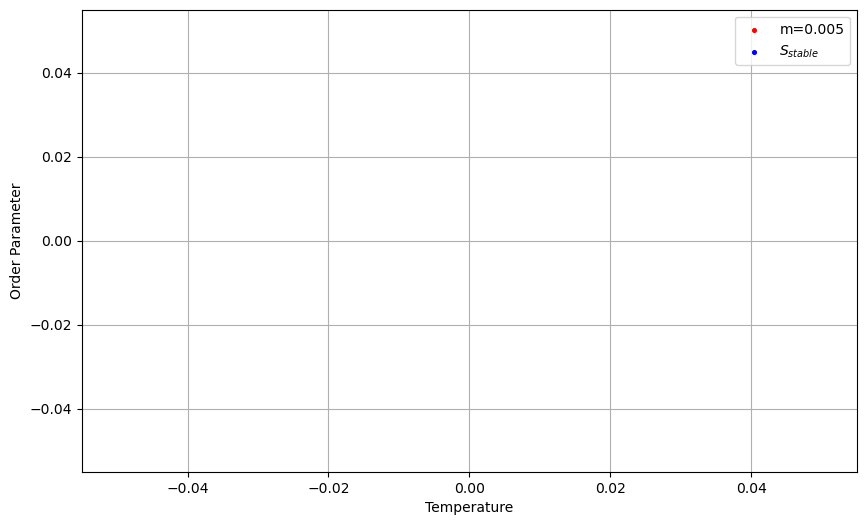

In [ ]:
def first_eqs(t, m, s):
    # ensure python float for stability
    s = float(s)  
    t = float(t)
    m = float(m)

    # clip exponent arguments to avoid overflow
    # choose safe_clip = 700 for np.exp (np.exp(700) ~ 1e304) 
    safe_clip = 700.0 
    a = - 3 * s / (4 * t) 
    b = m / t 
    a = np.clip(a, -safe_clip, safe_clip)
    b = np.clip(b, -safe_clip, safe_clip)
    exp1 = np.exp(a) 
    sinh = np.sinh(b) 

    denom =  m * exp1
    # avoid division by zero
    if denom == 0:
        return 1e6
    
    return -1 + s - 3 * sinh / denom 

def hessian(t, m, S): 

    safe_clip = 700.0
    a = (9/4) * S / t
    a2 = (9/2) * S / t
    b = m / t
    a = np.clip(a, -safe_clip, safe_clip)
    a2 = np.clip(a, -safe_clip, safe_clip)
    b = np.clip(b, -safe_clip, safe_clip)
    
    #precompute recurring terms with safe clip
    exp1 = np.exp(a)
    exp2 = np.exp(a2)
    cosh = np.cosh(b) 
    sinh = np.sinh(b) 

    #common denominators
    denom1 = (2 + exp1*cosh)*(2 + exp1*cosh)
    denom2 = 8*t + 4*exp1*t*cosh 

    # guard denominators
    denom1 = np.maximum(denom1, 1e-300)
    denom2 = np.maximum(denom2, 1e-300)

    #individual Hessian elements 
    H11 = 1 + 9/(4*t*denom1) - 9/denom2
    H12 = 9/(4*t*denom1) 
    H13 = (9*exp1*cosh)/(4*t*denom1) 
    H16 = (3*exp1*sinh)/(2*t*denom1) 
    H33 = 1 + 9/(t*denom1) - 9/(4*t + 2*exp1*t*cosh)
    H36 = -(3*exp1*sinh)/(t*denom1) 
    H44 = 1 - 1 / (2*t + exp1*t*cosh)
    H66 = 1 - (-4+ exp2)/(t*denom1) - 2/(2*t + exp1*t*cosh)
    # full Hessian matrix 
    hessian_matrix = np.array([
        [H11, H12, H13, 0.0, 0.0, H16],
        [H12, H11, H13, 0.0, 0.0, H16],
        [H13, H13, H33, 0.0, 0.0, H36],
        [0.0, 0.0, 0.0, H44, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, H44, 0.0],
        [H16, H16, H36, 0.0, 0.0, H66]
    ])

    # make symmetric
    hessian_matrix = 0.5 * (hessian_matrix + hessian_matrix.T)

    return hessian_matrix 

def stability_check(t, vars_, tol=-1e-9):
    m, S = vars_
    
    #return False (unstable / not defined) if any input is NaN or not finite
    if not (np.isfinite(t) and np.isfinite(m) and np.isfinite(S)):
        return False
    
    H = hessian(t, m, S)

    # check the matrix itself
    if not np.all(np.isfinite(H)):
        return False
    
    e = np.real_if_close(eigvals(H))
    
    # require all eigenvalues strictly greater than tol
    return np.all(e > tol)

m= 0.005

T_vals = np.linspace(0.005, 1.0, 500)
S_vals = []

for T in T_vals:
    # Solve for S
    sol = root_scalar(lambda S: first_eqs(T, m, S), method='newton', x0= S_vals[-1] if S_vals else 1.0)

    if sol.converged:
        S_vals.append(sol.root)
    else:
        # Try fallback
        sol = root_scalar(lambda S: first_eqs(T, m, S), method='bisect', bracket=[-1.0, 2.0])
        if sol.converged:
            S_vals.append(sol.root)
        else:
            S_vals.append(np.nan)  # Mark failure

S_stable=[]
T_stable=[]

for i in range(len(T_vals)): 
    if stability_check(T_vals[i],[m ,S_vals[i]]):
        S_stable.append(S_vals[i]) 
        T_stable.append(T_vals[i]) 


# Plot
fig=plt.figure(figsize=(10, 6))

plt.scatter(T_vals, S_vals, label=f'm={m}', color='red',s=7)
#plt.scatter(T_stable, S_stable, label=r'$S_{stable}$', color='blue',s=7) 

plt.xlabel('Temperature')
plt.ylabel('Order Parameter')
plt.legend()
plt.grid(True) 
plt.show() 
